# Check catalog alignment to Gaia

We'll load an input catalog, query Gaia DR3 using astroquery Vizier, match the catalogs, and then plot the offsets.

Hopefully it looks good! We won't measure the transformation (shift, scale, rotation, distortion) or do any corrections in this notebook.

In [1]:
# Import necessary libraries
import numpy as np
from astropy.table import Table
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

from astroquery.vizier import Vizier  # to query Gaia

import matplotlib.pyplot as plt

# Load the input catalog

In [2]:
# Input catalog
full_input_catalog = Table.read('../catalog/nircam_f115w_cat.ecsv')

input_catalog = full_input_catalog.copy()
input_catalog.rename_column('label', 'id')
input_catalog.rename_column('aper_total_abmag', 'mag')
input_catalog.rename_column('aper_total_abmag_err', 'mag_err')

input_coords = SkyCoord(input_catalog['sky_centroid'])
input_ra = input_coords.ra.deg
input_dec = input_coords.dec.deg
input_catalog['ra'] = input_ra * u.degree
input_catalog['dec'] = input_dec * u.degree

input_catalog = input_catalog['id', 'ra', 'dec', 'mag', 'mag_err']

input_catalog

id,ra,dec,mag,mag_err
,deg,deg,,
int64,float64,float64,float64,float64
1,9.171878290085605,39.537766428031134,24.293637,0.038331
2,9.173553392204933,39.5377726784693,24.105265,0.033546
3,9.1743253127068,39.53841711025011,24.437007,0.043481
4,9.170705532266336,39.53843486619157,24.296226,0.038971
5,9.173930599141666,39.539609777999,27.992012,0.773142
6,9.169862952858221,39.539614251578136,24.269711,0.039365
7,9.172491015678975,39.53983557415694,24.328276,0.039624
8,9.173356838405748,39.53987277676463,26.022443,0.164331


In [3]:
# Calculate the input catalog radius (roughly)
mean_coord = SkyCoord(ra=input_coords.ra.mean(), dec=input_coords.dec.mean())
separations = input_coords.separation(mean_coord)
max_separation = separations.max()
max_separation_arcmin = max_separation.to(u.arcmin).value
input_radius = max_separation_arcmin + 1  # arcmin (with a buffer)
print(f"Maximum distance from mean: {max_separation_arcmin}")

Maximum distance from mean: 4.196296716281745


# Query Gaia DR3 and match catalogs

https://astroquery.readthedocs.io/en/latest/vizier/vizier.html

In [4]:
# Query the Gaia catalog from Vizier (as performed in Grizli)
# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/355 
search_center = coord.SkyCoord(ra=input_ra.mean(), dec=input_dec.mean(), unit=(u.deg, u.deg), frame="icrs")
v = Vizier(catalog="I/355/gaiadr3", columns=["DR3Name", "+_r", "RA_ICRS", "DE_ICRS", "Gmag", "e_Gmag"])
v.ROW_LIMIT = max_rows = 100000
search_radius = input_radius  # arcmin
gaia_catalog = v.query_region(search_center, radius=f"{search_radius}m", catalog="I/355/gaiadr3")[0]

# Rename columns
#gaia_catalog.rename_column('_r', 'r_search')  # distance from search center
gaia_catalog.remove_column('_r')
gaia_catalog.rename_column('RA_ICRS', 'ra')
gaia_catalog.rename_column('DE_ICRS', 'dec')
gaia_catalog.rename_column('Gmag', 'mag')
gaia_catalog.rename_column('e_Gmag', 'mag_err')

gaia_coords = SkyCoord(ra=gaia_catalog['ra'], dec=gaia_catalog['dec'])

gaia_catalog

DR3Name,ra,dec,mag,mag_err
,deg,deg,mag,mag
str28,float64,float64,float64,float64
Gaia DR3 380696830146532352,9.11026847340,39.58634026869,19.186350,0.003899
Gaia DR3 380696834442890368,9.12156652991,39.58492322349,15.222967,0.002769
Gaia DR3 380696933225750912,9.12100865151,39.60066642002,18.545486,0.003393
Gaia DR3 380696898866012672,9.11345709066,39.60148308045,21.436180,0.031709
Gaia DR3 380696864506271872,9.12864835451,39.58865910671,19.003630,0.003579
Gaia DR3 380696830146580224,9.11861666355,39.57958865458,20.496930,0.007035
Gaia DR3 380696898866013440,9.10729108561,39.60341456782,18.807600,0.003384
Gaia DR3 380696525205502848,9.10112908127,39.58618438197,20.292982,0.017688


In [5]:
# Match the input catalog to the Gaia catalog
gaia_idx, distance_2d, distance_3d = input_coords.match_to_catalog_sky(gaia_coords)

max_separation = 1.0 * u.arcsec  # tolerance for match in arcsec
matches = distance_2d < max_separation  # match? True or False

In [6]:
input_matched_catalog = input_catalog[matches]
input_matched_catalog

id,ra,dec,mag,mag_err
,deg,deg,,
int64,float64,float64,float64,float64
266,9.175080521588523,39.55252215079291,19.782141,0.003632
270,9.157105411734095,39.5526992964778,18.464531,0.002075
346,9.1777891719039,39.554830691228545,20.652154,0.004682
479,9.135961748326276,39.559749969785976,18.100636,nan
737,9.162091025370945,39.56175700005188,19.479500,0.001948
780,9.162178835846559,39.562284507908615,19.226486,0.002242
927,9.140048129699094,39.56441590379243,17.718002,0.001548
1277,9.121528972354783,39.568696788821136,17.313127,0.003213


In [7]:
gaia_matched_catalog = gaia_catalog[gaia_idx[matches]]
gaia_matched_catalog

DR3Name,ra,dec,mag,mag_err
,deg,deg,mag,mag
str28,float64,float64,float64,float64
Gaia DR3 380695764994635392,9.17509582735,39.55250734355,20.451550,0.007658
Gaia DR3 380695799354373888,9.15711471090,39.55268658896,18.864063,0.003496
Gaia DR3 380695764994636032,9.17780023706,39.55481418863,20.564648,0.008664
Gaia DR3 380696555268606976,9.13595523565,39.55978191626,14.531949,0.002766
Gaia DR3 380695833714115200,9.16209575776,39.56174180704,20.617012,0.009152
Gaia DR3 380695833720720384,9.16218545551,39.56227824588,20.979374,0.019855
Gaia DR3 380696555268621312,9.14006390068,39.56440364618,18.259981,0.003134
Gaia DR3 380696623988098688,9.12153947736,39.56869165900,18.799830,0.003559


# Show offsets

In [8]:
# Offsets in degrees
delta_ra  = gaia_matched_catalog['ra']  - input_matched_catalog['ra']
delta_dec = gaia_matched_catalog['dec'] - input_matched_catalog['dec']

# Convert to arcsec
mean_dec = input_catalog['dec'].mean()
delta_ra = delta_ra * np.cos(mean_dec * np.pi / 180)  # on a sphere
delta_ra  = delta_ra * u.degree.to(u.arcsec)
delta_dec = delta_dec * u.degree.to(u.arcsec)

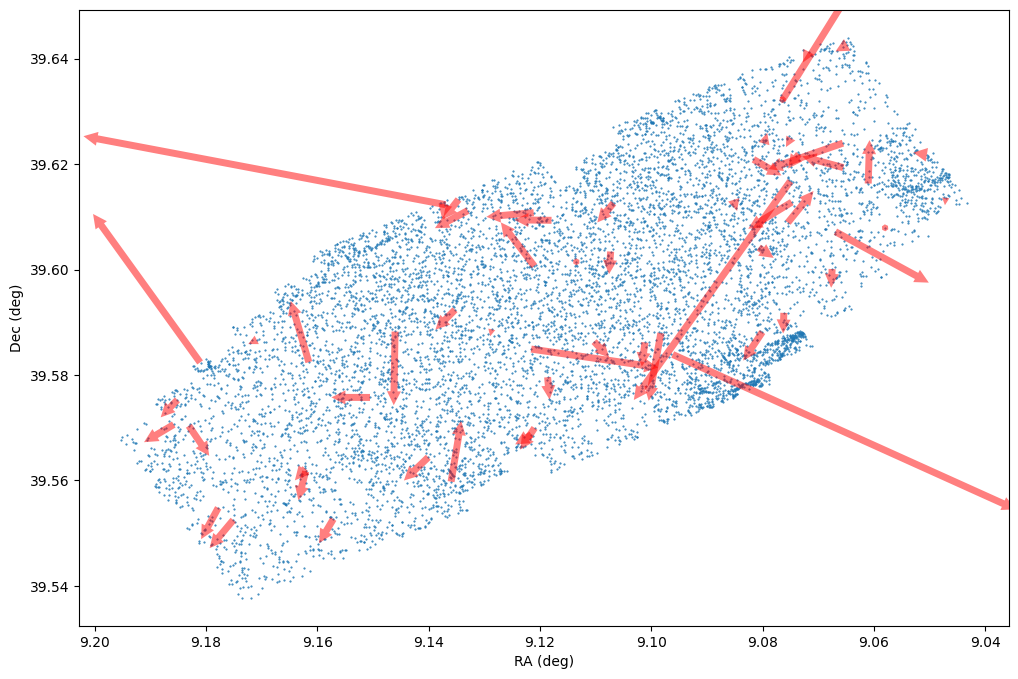

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
# Plot the original positions
ax.plot(input_catalog['ra'], input_catalog['dec'], '.', ms=1, zorder=-1)

d_factor = 0.1  # scale factor for arrow sizes (change as needed)
ax.quiver(gaia_matched_catalog['ra'].data, gaia_matched_catalog['dec'].data, 
           delta_ra.data*d_factor, delta_dec.data*d_factor, 
           angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5,
           headwidth=2, headlength=2, headaxislength=2, lw=1)

ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
plt.xlim(plt.xlim()[::-1])  # flip RA axis (East left)
plt.show()

In [10]:
print(f"Mean offset: {delta_ra.data.mean()} arcsec, {delta_dec.data.mean()} arcsec")

Mean offset: 0.013474973657366237 arcsec, -0.013909658686323947 arcsec


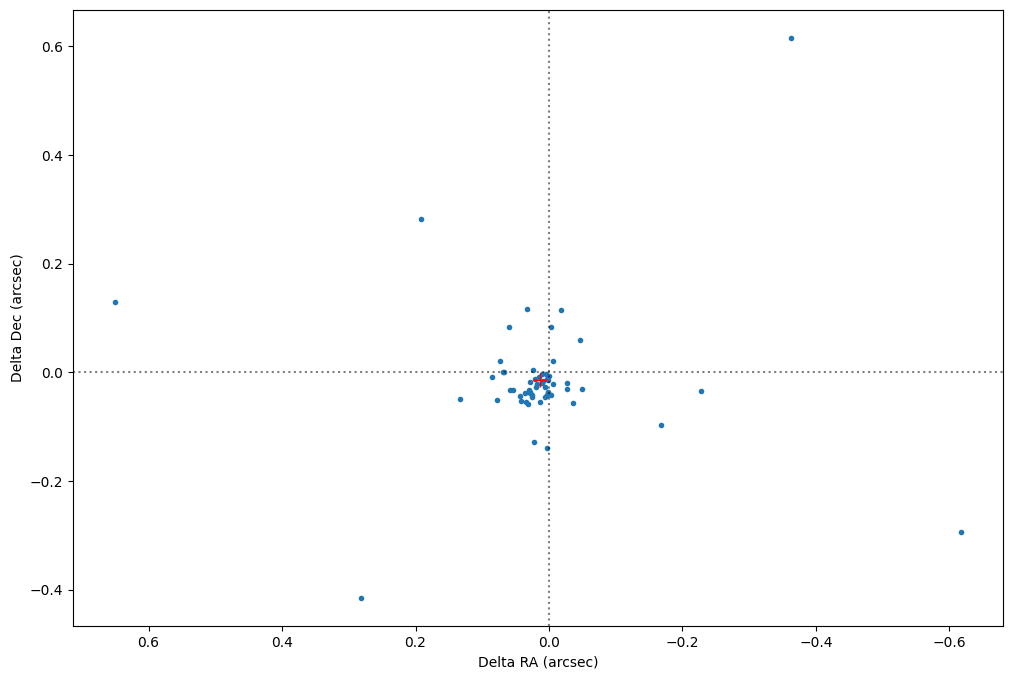

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(delta_ra.data, delta_dec.data, '.')
ax.plot(delta_ra.data.mean(), delta_dec.data.mean(), '+', ms=10, color='r')
ax.set_xlabel('Delta RA (arcsec)')
ax.set_ylabel('Delta Dec (arcsec)')
plt.axhline(0, color='k', linestyle=':', alpha=0.5)
plt.axvline(0, color='k', linestyle=':', alpha=0.5)
plt.xlim(plt.xlim()[::-1])  # flip RA axis (East left)
plt.show()

In [12]:
def prune_outliers_2d(x, y, n_sigma=4, max_iterations=10):
    points = np.column_stack((x, y))
    print(len(points), 'points')
    
    for _ in range(max_iterations):
        mean_pos = np.mean(points, axis=0)
        distances = np.linalg.norm(points - mean_pos, axis=1)  # distance from mean: sqrt(dx^2 + dy^2)
        std_dev = np.std(distances)
        mask = distances < n_sigma * std_dev
        if np.sum(mask) == len(points):  # didn't reject any this time
            break
        
        points = points[mask]
    
        print(len(points), 'points: RMS =', std_dev, 'arcsec')
        
    return points[:, 0], points[:, 1]

58 points
55 points: RMS = 0.16104418178370475 arcsec
53 points: RMS = 0.08387970970787713 arcsec
52 points: RMS = 0.04908595789441984 arcsec
51 points: RMS = 0.04181783522816587 arcsec


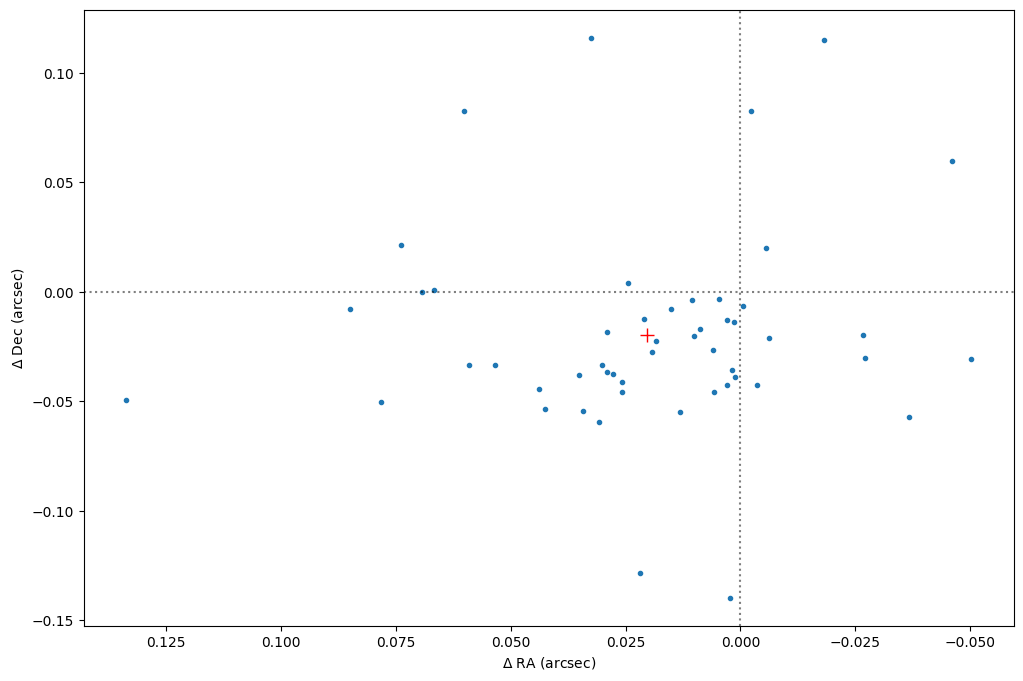

In [13]:
delta_ra_pruned, delta_dec_pruned = prune_outliers_2d(delta_ra.data, delta_dec.data)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(delta_ra_pruned, delta_dec_pruned, '.')
ax.plot(delta_ra_pruned.mean(), delta_dec_pruned.mean(), '+', ms=10, color='r')
ax.set_xlabel(r'$\Delta$ RA (arcsec)')
ax.set_ylabel(r'$\Delta$ Dec (arcsec)')
plt.axhline(0, color='k', linestyle=':', alpha=0.5)
plt.axvline(0, color='k', linestyle=':', alpha=0.5)
plt.xlim(plt.xlim()[::-1])  # flip RA axis (East left)
plt.show()

In [14]:
print(f"Mean offset: {delta_ra_pruned.mean()} arcsec, {delta_dec_pruned.mean()} arcsec")

Mean offset: 0.020272863069158497 arcsec, -0.01947889888841099 arcsec
